In [78]:
from sklearn import neural_network
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from datetime import datetime
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [79]:
cleaned_data = pd.read_csv('data/clean_4hours.csv',parse_dates = ['index10'], squeeze=True)
cleaned_data = cleaned_data.set_index(pd.DatetimeIndex(cleaned_data['index10'])).drop(['index10'], axis=1)

In [80]:
cleaned_data.head()

,Humidity,Temperature(C),GHI,Hour,Month,Output_power,previous
index10,,,,,,,
2020-09-20 20:00:00,77,10,0,21,9,0.00000,0.00000
2020-09-21 00:00:00,89,10,0,1,9,0.00000,0.00000
2020-09-21 04:00:00,90,11,101,5,9,0.08138,0.00000
2020-09-21 08:00:00,75,14,225,9,9,2.84375,0.08138
2020-09-21 12:00:00,75,14,96,13,9,3.82487,2.84375


## Train-test Split and Transformation 

In [81]:
x, y = cleaned_data.drop(['Output_power'],axis=1), cleaned_data['Output_power']
y = np.sqrt(y)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

## Feature Scaling

In [82]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

## Mape 

In [83]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """
    convert inputs to numpy array.
    drop zeros in y_true. 
    calculate MAPE.
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    y_pred = y_pred[y_true != 0]
    y_true = y_true[y_true != 0]
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## KNN

In [84]:
from sklearn.neighbors import KNeighborsRegressor
model_knn = KNeighborsRegressor(n_neighbors=3, p = 1)
model_knn.fit(x_train, y_train)
y_pred_knn = model_knn.predict(x_test)

In [85]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error

df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_knn),
    'MAE': mean_absolute_error(y_test,y_pred_knn),
    #'MSE': mean_squared_error(y_test,y_pred_knn),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_knn)),
    #'nRMSE': (math.sqrt(mean_squared_error(y_test,y_pred_knn)))/y_test.mean(),
    'R-Squared': r2_score(y_test, y_pred_knn),
    'Predicted Standard Deviation of Test Set': np.std(y_pred_knn),
    'Actual Standard Deviation of Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)


,Value
MAPE,19.069518
MAE,0.078929
RMSE,0.170713
R-Squared,0.969146
Predicted Standard Deviation of Test Set,0.964024
Actual Standard Deviation of Test Set,0.971870


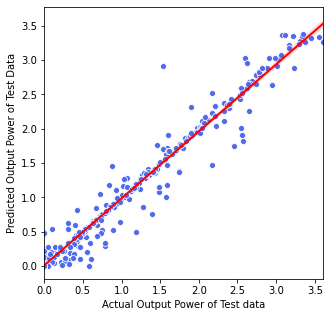

In [86]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_pred_knn, color = '#516BEB')
sns.regplot(y_test,y_pred_knn,scatter=False,scatter_kws={'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})

plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation for KNN 

In [87]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_knn = cross_val_score(model_knn, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_knn)) + ", r2: " + str(np.mean(np.abs(scores_knn))) + ", STD:"+ str(np.std(scores_knn)))


Folds: 10, r2: 0.96807456013801, STD:0.011836539541177674


## XGBoost

In [89]:
# xgboost model
model_xgboost = XGBRegressor(n_estimators=250, learning_rate=0.1,subsample=.6, max_depth=5)
model_xgboost.fit(x_train, y_train)
y_pred_xgboost = model_xgboost.predict(x_test)

In [90]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_xgboost),
    'MAE': mean_absolute_error(y_test,y_pred_xgboost),
    #'MSE': mean_squared_error(y_test,y_pred_xgboost),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_xgboost)),
    'R-Squared': r2_score(y_test, y_pred_xgboost),
    'Standard Deviation of predicted Test Set': np.std(y_pred_xgboost),
    'Actual Standard Deviation of actual Test Set': np.std(y_test),
    
   
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,14.631450
MAE,0.071536
RMSE,0.143412
R-Squared,0.978225
Standard Deviation of predicted Test Set,0.955452
Actual Standard Deviation of actual Test Set,0.971870


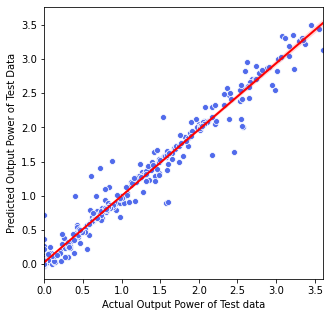

In [91]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_pred_xgboost, color = '#516BEB')
sns.regplot(y_test,y_pred_xgboost,scatter=False,scatter_kws={'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})

plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")

plt.show()

## Cross Validation of XGBoost

In [92]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_xg = cross_val_score(model_xgboost, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_xg)) + ", r2: " + str(np.mean(np.abs(scores_xg))) + ", STD:"+ str(np.std(scores_xg)))

Folds: 10, r2: 0.9806808713494668, STD:0.004146809473685857


## MLP 

In [107]:
model_mlp = neural_network.MLPRegressor(hidden_layer_sizes=(80,80),
                                        activation='relu',
                                        solver='adam',
                                        learning_rate='invscaling',
                                        max_iter=200, 
                                        
                           )
model_mlp.fit(x_train, y_train)
y_pred_mlp = model_mlp.predict(x_test)

In [108]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_mlp),
    'MAE': mean_absolute_error(y_test,y_pred_mlp),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_mlp)),
    'R-Squared': r2_score(y_test, y_pred_mlp),
    'Standard Deviation of predicted Test Set': np.std(y_pred_mlp),
    'Standard Deviation of actual Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,23.244810
MAE,0.089836
RMSE,0.151835
R-Squared,0.975592
Standard Deviation of predicted Test Set,0.945021
Standard Deviation of actual Test Set,0.971870


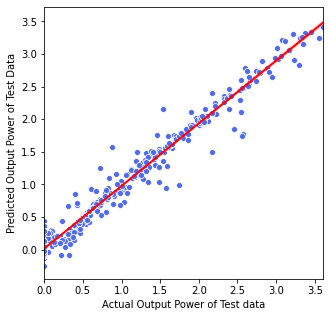

In [109]:
plt.figure(figsize=(5,5))
sns.scatterplot(y_test, y_pred_mlp, color = '#516BEB')
sns.regplot(y_test,y_pred_mlp,scatter=False,scatter_kws={'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})

plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation MLP

In [110]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_mlp = cross_val_score(model_mlp, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_mlp)) + ", r2: " + str(np.mean(np.abs(scores_mlp))) + ", STD:"+ str(np.std(scores_mlp)))

Folds: 10, r2: 0.9688014518633541, STD:0.007170211909437196


## SVR 

In [111]:
# SVR model with sklearn
from sklearn.svm import SVR
model_svm = SVR(C =5, kernel='rbf', gamma= 0.6)
model_svm.fit(x_train, y_train.ravel())
y_pred_svm = model_svm.predict(x_test)

In [112]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_svm),
    'MAE': mean_absolute_error(y_test,y_pred_svm),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_svm)),
    'R-Squared': r2_score(y_test, y_pred_svm),
    'Standard Deviation of predicted Test Set': np.std(y_pred_svm),
    'Standard Deviation of actual Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,25.454950
MAE,0.106968
RMSE,0.167582
R-Squared,0.970267
Standard Deviation of predicted Test Set,0.944816
Standard Deviation of actual Test Set,0.971870


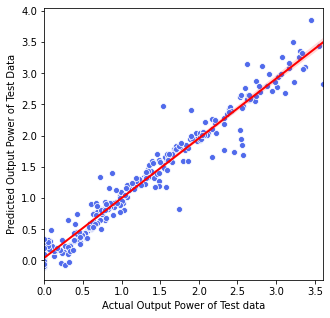

In [113]:
plt.figure(figsize=(5,5))
#plt.scatter(y_test, y_pred_xgboost)
sns.scatterplot(y_test, y_pred_svm,color = '#516BEB')

sns.regplot(y_test,y_pred_svm,scatter = False,scatter_kws = {'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})
plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation of SVR

In [114]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_svr = cross_val_score(model_svm, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_svr)) + ", r2: " + str(np.mean(np.abs(scores_svr))) + ", STD:"+ str(np.std(scores_svr)))

Folds: 10, r2: 0.9666137389024831, STD:0.010218821586679187


## Random Forest

In [116]:
# Random Forest model with sklearn
from sklearn.ensemble import RandomForestRegressor
model_random_forest = RandomForestRegressor(n_estimators=200, max_features= 'log2')
model_random_forest.fit(x_train, y_train)
y_pred_random_forest = model_random_forest.predict(x_test)

In [117]:
from sklearn.metrics import mean_absolute_error
df_results = pd.DataFrame.from_dict({
    
    'MAPE': mean_absolute_percentage_error(y_test,y_pred_random_forest),
    'MAE': mean_absolute_error(y_test,y_pred_random_forest),
    #'MSE': mean_squared_error(y_test,y_pred_svm),
    'RMSE': math.sqrt(mean_squared_error(y_test,y_pred_random_forest)),
    'R-Squared': r2_score(y_test, y_pred_random_forest),
    'Predicted Standard Deviation of Test Set': np.std(y_pred_random_forest),
    'Actual Standard Deviation of Test Set': np.std(y_test),
    
},orient='index', columns=['Value'])
display(df_results)

,Value
MAPE,16.459632
MAE,0.068444
RMSE,0.138665
R-Squared,0.979643
Predicted Standard Deviation of Test Set,0.941778
Actual Standard Deviation of Test Set,0.971870


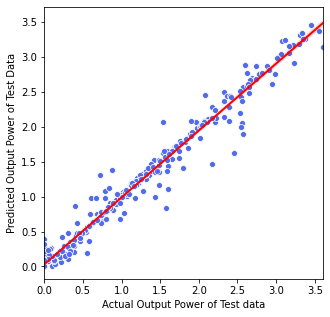

In [118]:
plt.figure(figsize=(5,5))
#plt.scatter(y_test, y_pred_xgboost)
sns.scatterplot(y_test, y_pred_random_forest,color = '#516BEB')

sns.regplot(y_test,y_pred_random_forest,scatter = False,scatter_kws = {'s': 100, 'alpha': 0.5, 'color': '#270082'},
            line_kws={'lw': 2, 'color': 'r'})
plt.xlabel("Actual Output Power of Test data")
plt.ylabel("Predicted Output Power of Test Data")
plt.show()

## Cross Validation RF

In [119]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

crossvalidation = KFold(n_splits=10, random_state=42, shuffle=True)
scores_rf = cross_val_score(model_random_forest, x_train, y_train, scoring="r2", cv=crossvalidation, n_jobs=1)

print("Folds: " + str(len(scores_rf)) + ", r2: " + str(np.mean(np.abs(scores_rf))) + ", STD:"+ str(np.std(scores_rf)))

#neg_mean_absolute_error



Folds: 10, r2: 0.9796720733308492, STD:0.004671850214893718
